In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
%matplotlib inline

In [2]:
train = pd.read_csv('final_train_data.csv')
test = pd.read_csv('final_test_data.csv')

In [3]:
print(train.shape)
print(test.shape)

(3333, 66)
(1667, 66)


# Modeling and Performance

In [4]:
#train X and Y splitting
X_train = train.drop('churn_num', axis = 1)
Y_train = train['churn_num']

#Test X ad Y splitting
X_test = test.drop('churn_num', axis = 1)
Y_test = test['churn_num']


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

### Logistic Regression

In [6]:
lr = LogisticRegression(random_state=44, solver='liblinear')
param_gridd = {'penalty' : ['l1', 'l2'], 'C' : [0.1, 1, 2, 3, 5]}
CV_lr = GridSearchCV(estimator=lr, param_grid=param_gridd, cv=5)
CV_lr.fit(X_train, Y_train)
lr_best = CV_lr.best_estimator_

In [7]:
lr_best

LogisticRegression(C=3, penalty='l1', random_state=44, solver='liblinear')

In [8]:
'''The function predict_proba() returns a numpy array of two columns. 
The first column is the probability that target=0 and the second column is the probability that target=1'''
test_score_lr = lr_best.predict_proba(X_test)[:, 1]
pd.Series(test_score_lr).describe()

count    1667.000000
mean        0.146747
std         0.170207
min         0.001241
25%         0.036857
50%         0.079415
75%         0.189093
max         0.988504
dtype: float64

In [9]:
from sklearn.metrics import classification_report

In [10]:
print(classification_report(Y_test, (test_score_lr >= 0.5)))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1443
           1       0.56      0.23      0.33       224

    accuracy                           0.87      1667
   macro avg       0.72      0.60      0.63      1667
weighted avg       0.85      0.87      0.85      1667



### Gradient Bossting Classifier

In [11]:
gbc = GradientBoostingClassifier(random_state=42)
param_grid_gbc = {'n_estimators' : [50, 100, 500], 'max_features' : ['auto'], 'learning_rate' : [0.01, 0.05, 0.1, 0.2]}
CV_gbc = GridSearchCV(estimator=gbc, param_grid=param_grid_gbc, cv=5)
CV_gbc.fit(X_train, Y_train)

gbc_best = CV_gbc.best_estimator_
print(gbc_best)

GradientBoostingClassifier(learning_rate=0.05, max_features='auto',
                           n_estimators=500, random_state=42)


In [12]:
test_score_gbc = gbc_best.predict_proba(X_test)[:,1]
pd.Series(test_score_gbc).describe(percentiles = [.75,.90,.95])

count    1667.000000
mean        0.129066
std         0.261440
min         0.000514
50%         0.024422
75%         0.053640
90%         0.562020
95%         0.923120
max         0.999998
dtype: float64

In [13]:
print(classification_report(Y_test, (test_score_gbc >= 0.5)))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1443
           1       0.93      0.72      0.81       224

    accuracy                           0.95      1667
   macro avg       0.94      0.85      0.89      1667
weighted avg       0.95      0.95      0.95      1667



#### Performance Comparison of models

In [14]:
from sklearn.metrics import auc, average_precision_score, f1_score, confusion_matrix, roc_auc_score, accuracy_score, log_loss, roc_curve, precision_recall_curve

In [15]:
#Area Under ROC and PR curves for LR model
roc_auc_lr = roc_auc_score(Y_test, test_score_lr, average = 'macro')
avg_pre_lr = average_precision_score(Y_test, test_score_lr)
print("Area Under the ROC Curve from prediction scores: "+ str(round(roc_auc_lr*100, 2))+'%')
print("Average precision (AP) from prediction scores: "+ str(round(avg_pre_lr*100, 2)) + '%')

Area Under the ROC Curve from prediction scores: 83.37%
Average precision (AP) from prediction scores: 46.13%


In [16]:
#Area Under ROC and average Precision score for GBC model
roc_auc_gbc= roc_auc_score(Y_test, test_score_gbc, average='macro')
avg_pre_gbc = average_precision_score(Y_test, test_score_gbc)
print("Area Under the ROC Curve from prediction scores: "+ str(round(roc_auc_gbc*100, 2))+'%')
print("Average precision (AP) from prediction scores: "+ str(round(avg_pre_gbc*100, 2)) + '%')

Area Under the ROC Curve from prediction scores: 92.16%
Average precision (AP) from prediction scores: 85.05%


#### ROC curve Between GBC model and LR model

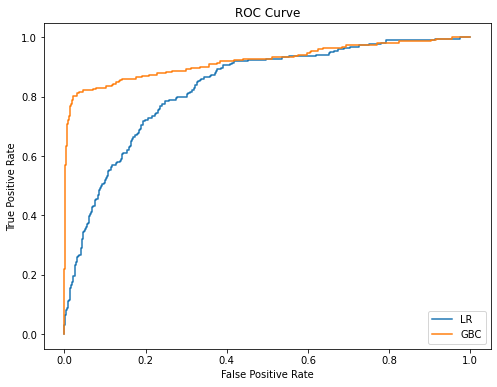

In [17]:
plt.figure(figsize=(8,6))
fpr_lr, tpr_lr, _ = roc_curve(Y_test, test_score_lr)
plt.plot(fpr_lr, tpr_lr, label = 'LR')

fpr_gbc, tpr_gbc, _ = roc_curve(Y_test, test_score_gbc)
plt.plot(fpr_gbc, tpr_gbc, label = 'GBC')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate'); plt.ylabel("True Positive Rate")
plt.legend(loc = 'lower right')
plt.show()

#### PR curve Between GBC model and LR model

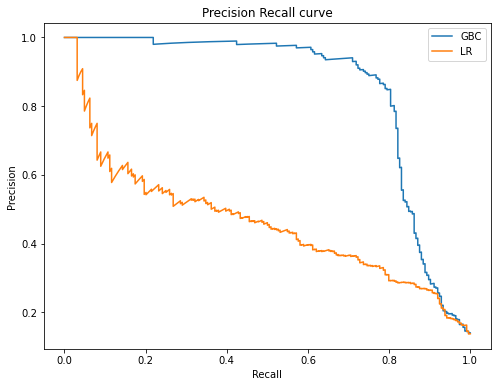

In [18]:
plt.figure(figsize=(8,6))
precision_gbc, recall_gbc, _ =precision_recall_curve(Y_test, test_score_gbc)
plt.plot(recall_gbc, precision_gbc, label ='GBC')
precision_lr, recall_lr, _ =precision_recall_curve(Y_test, test_score_lr)
plt.plot(recall_lr, precision_lr, label ='LR')
plt.xlabel('Recall'); 
plt.ylabel('Precision')
plt.title('Precision Recall curve')
plt.legend()
plt.show()

#### Confusion Matrix for GBC Model

[Text(0, 0.5, 'retained'), Text(0, 1.5, 'churned')]

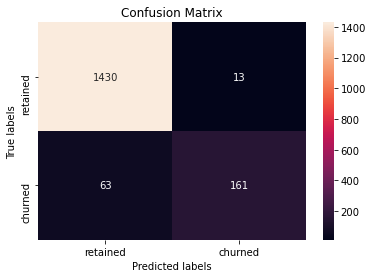

In [19]:
cm = confusion_matrix(Y_test, (test_score_gbc>=0.5))
ax = plt.subplot()
sns.heatmap(cm, annot= True, ax= ax, fmt= 'g')
ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['retained', 'churned'])
ax.yaxis.set_ticklabels(['retained', 'churned'])

**Other Method**

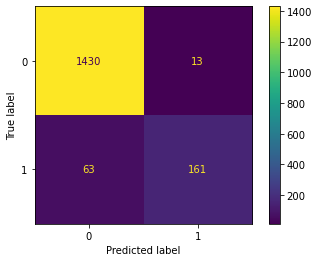

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, (test_score_gbc>=0.5), labels=gbc_best.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=gbc_best.classes_)
disp.plot()

plt.show()

**Looking at accuracy Score of both the models**

In [21]:
print(accuracy_score(Y_test, (test_score_lr >= 0.5), normalize=True))
print(accuracy_score(Y_test, (test_score_gbc >= 0.5), normalize=True))

0.8722255548890222
0.9544091181763648


#### Selecting top 10% of the data

In [22]:
get_top10 = pd.concat([pd.Series(test_score_gbc, name='model_score'), Y_test], axis = 1)
get_top10 = get_top10.sort_values(by = 'model_score', ascending=False)
print(get_top10.head(10))
print('*'*40)
print(get_top10.head(round(get_top10.shape[0]*0.1))['churn_num'].value_counts())

      model_score  churn_num
857      0.999998          1
1143     0.999632          1
153      0.999390          1
1591     0.998999          1
660      0.998696          1
1626     0.998550          1
633      0.997440          1
1581     0.997045          1
109      0.996817          1
1610     0.996406          1
****************************************
1    157
0     10
Name: churn_num, dtype: int64


#### Function to get the Feature Importance

In [23]:
def get_FI(modelname, dfname):
    importance_list = pd.DataFrame(modelname.feature_importances_, columns=['importance'])
    varnames_list = pd.DataFrame(dfname.columns.tolist(), columns=['feature'])
    feature_importance = pd.concat([varnames_list, importance_list], axis=1, join='inner')
    feature_importance = feature_importance.sort_values(by=['importance'], ascending=False)
    feature_importance['cum_importance'] = feature_importance['importance'].cumsum()
    return feature_importance

In [24]:
get_FI(gbc_best, X_train).tail(55)

,feature,importance,cum_importance
7,total_night_calls,6.173101e-03,0.966616
5,total_eve_calls,5.361931e-03,0.971978
0,account_length,5.186791e-03,0.977165
43,state_NJ,2.070559e-03,0.979236
31,state_MA,1.884425e-03,0.981120
49,state_OR,1.813565e-03,0.982934
46,state_NY,1.803572e-03,0.984737
41,state_NE,1.153850e-03,0.985891
14,state_AR,1.078706e-03,0.986970
55,state_TX,1.017691e-03,0.987987


**Since**, Area and state columns are not adding much importance to the dataset, we will remove them

#### Recursive Feature Elimination

In [25]:
state_area_var = [x for x in X_train.columns if 'area' in x or 'state' in x]
print(len(state_area_var))

X_train_rfe = X_train.drop(state_area_var, axis = 1)
X_test_rfe = X_test.drop(state_area_var, axis = 1)
print(X_test_rfe.shape)

52
(1667, 13)


In [26]:
get_FI(gbc_best, X_test_rfe)

,feature,importance,cum_importance
2,total_day_minutes,0.269874,0.269874
10,number_customer_service_calls,0.159555,0.429429
4,total_eve_minutes,0.135305,0.564734
8,total_intl_minutes,0.106098,0.670833
11,international_plan_num,0.086014,0.756847
1,number_vmail_messages,0.082980,0.839827
9,total_intl_calls,0.080857,0.920684
12,charge_per_minute,0.016792,0.937476
6,total_night_minutes,0.016115,0.953591
3,total_day_calls,0.006852,0.960443


#### Training GBDT model on reduced feature set

In [27]:
# Gradient Boosting on reduced feature set
gbr=GradientBoostingClassifier(random_state=42)
param_grid = { 
'n_estimators': [50, 100, 500], 'max_features': ['auto'], 'learning_rate': [0.01, 0.05, 0.1, 0.2]
}
CV_gbr = GridSearchCV(estimator=gbr, param_grid=param_grid, cv= 5)
CV_gbr.fit(X_train_rfe, Y_train)
gbr_best_rfe = CV_gbr.best_estimator_
print(gbr_best_rfe)

GradientBoostingClassifier(learning_rate=0.05, max_features='auto',
                           n_estimators=500, random_state=42)


#### Testing Model on Reduced feature set

In [28]:
test_score_rfe = gbr_best_rfe.predict_proba(X_test_rfe)[:, 1]
print(pd.Series(test_score_rfe).describe())
roc_auc_gbm = (roc_auc_score(Y_test, test_score_rfe, average='macro'))
avg_pre_gbm = average_precision_score(Y_test, test_score_rfe)
print('*'*40)
print('New Score')
print('*'*40)
print (roc_auc_gbm*100)
print (avg_pre_gbm*100)
print('*'*40)
print('Old Score')
print('*'*40)
print('92.16%')
print('85.05%')

count    1667.000000
mean        0.127592
std         0.260729
min         0.001585
25%         0.015223
50%         0.024144
75%         0.052756
max         0.999968
dtype: float64
****************************************
New Score
****************************************
92.46268933768934
85.31791580776711
****************************************
Old Score
****************************************
92.16%
85.05%


In [29]:
print(classification_report(Y_test, (test_score_rfe >= 0.5)))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1443
           1       0.92      0.71      0.80       224

    accuracy                           0.95      1667
   macro avg       0.94      0.85      0.89      1667
weighted avg       0.95      0.95      0.95      1667



#### Getting important features for reduced set

In [30]:
FI = get_FI(gbr_best_rfe, X_train_rfe)
print(FI)

                          feature  importance  cum_importance
2               total_day_minutes    0.272470        0.272470
10  number_customer_service_calls    0.164502        0.436973
4               total_eve_minutes    0.142622        0.579594
8              total_intl_minutes    0.103509        0.683103
11         international_plan_num    0.086615        0.769718
1           number_vmail_messages    0.085081        0.854799
9                total_intl_calls    0.079327        0.934126
12              charge_per_minute    0.020380        0.954506
6             total_night_minutes    0.018011        0.972518
5                 total_eve_calls    0.008066        0.980584
3                 total_day_calls    0.007211        0.987795
7               total_night_calls    0.006141        0.993935
0                  account_length    0.006065        1.000000


# Key Drivers of Churn

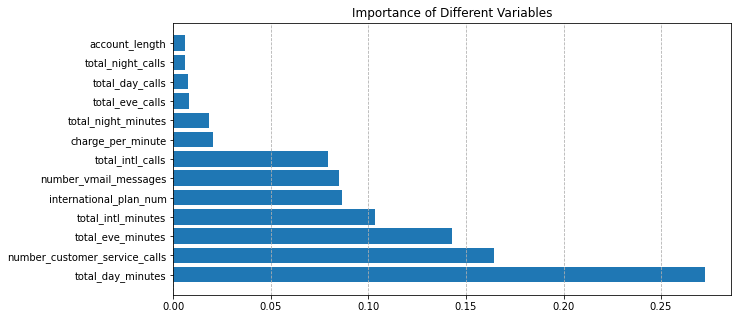

In [31]:
plt.figure(figsize=(10,5))
vals = list(FI['importance'])
plt.barh(FI['feature'], FI['importance'])
plt.title('Importance of Different Variables')
plt.gca().xaxis.grid(linestyle = '--')

# Model Implementation

Python pickle module is used for serializing and de-serializing a Python object structure. Any object in Python can be pickled so that it can be saved on disk.<br>What pickle does is that it “serializes” the object first before writing it to file. Pickling is a way to convert a python object (list, dict, etc.) into a character stream. The idea is that this character stream contains all the information necessary to reconstruct the object in another python script.

In [32]:
#Saving the required files
import pickle
model_columns = list(X_train_rfe.columns)
pickle.dump(gbr_best_rfe, open('model.pkl', 'wb'))
pickle.dump(model_columns, open('model_columns.pkl', 'wb'))